In [11]:
import os
import sys
import shutil
# Detect if running in Google Colab

# Set the environment variable for your GitHub token
#os.environ["GITHUB_TOKEN"] =

# This cell is for loading data. If your prefer to do this manually, you will need to set base_dir and data_dir separately

IN_COLAB = 'google.colab' in sys.modules

# Check if running in Google Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # Set the base directory on Google Drive (no extra folder will be added)
    base_dir = "/content/drive/MyDrive/Bertopic"
    token = os.getenv("GITHUB_TOKEN")
    #if os.path.exists(base_dir):
     #   shutil.rmtree(base_dir)

    #!git clone https://{token}@github.com/UnbrokenCocoon/OCR-evaluation.git "{base_dir}"

else:
    # Set the base directory locally (set this to your local project folder)
    base_dir = "path/to/your/local/project/folder"

    #!git clone https://{token}@github.com/UnbrokenCocoon/OCR-evaluation.git "{base_dir}"

    # Clone the repository locally


# Set the data directory (this assumes you have a 'Data' folder inside the repository)
data_dir = os.path.join(base_dir, "Data")
output_dir = os.path.join(base_dir, "output")
os.makedirs(output_dir, exist_ok=True)

# Now data_dir points to the cloned Data folder
print(f"Data folder is located at: {data_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data folder is located at: /content/drive/MyDrive/Bertopic/Data


In [18]:
import pandas as pd
batch_1 = pd.read_csv(os.path.join(data_dir, 'batch_1.csv'))
batch_2 = pd.read_csv(os.path.join(data_dir, 'batch_2.csv'))
metrics_df = pd.concat([batch_1, batch_2])

print(batch_1)
print(batch_2)
print(metrics_df)

    Unnamed: 0  Error_Size  Topic_20_Size  Gini_Score  Stability_Score  \
0            0       52761            511    0.597927             1146   
1            1       41846            117    0.762486              884   
2            2       49121            363    0.609585             1059   
3            3       41846            117    0.762486              884   
4            4       41846            117    0.762486              884   
..         ...         ...            ...         ...              ...   
86          55       50933            414    0.666051              206   
87          56       52821            599    0.574261              254   
88          57       50933            414    0.666051              206   
89          58       52821            599    0.574261              254   
90          59       42117            200    0.739822              199   

    Keyword_Freq_Score  
0                 0.18  
1                 0.15  
2                 0.17  
3          

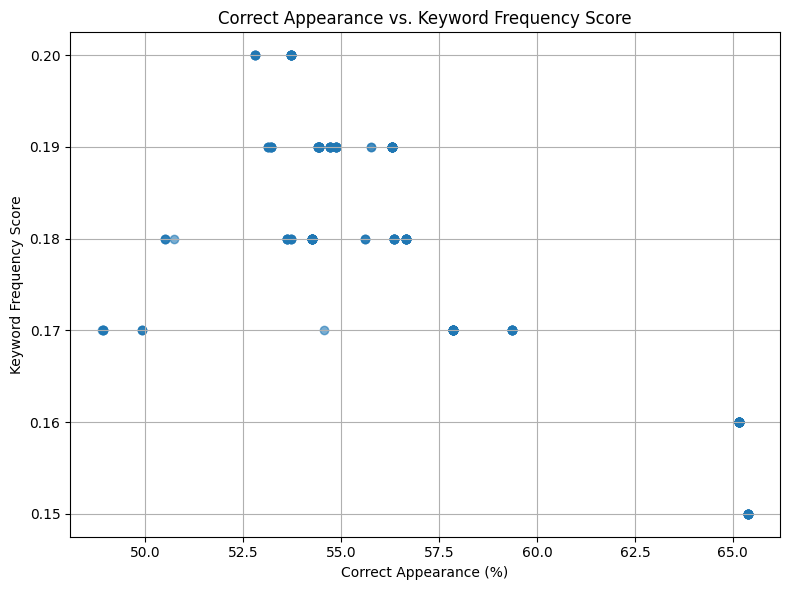

In [19]:
import pickle

# Load sentence list
with open(os.path.join(data_dir, 'bs_sen.pkl'), 'rb') as f:
    bs_sen = pickle.load(f)

# Total sentence count
sen_total = len(bs_sen)

# Add normalised column to metrics_df
metrics_df["Percentage Appearance"] = 100 - (metrics_df["Error_Size"] / sen_total * 100)
metrics_df["Percentage Appearance"] = metrics_df["Percentage Appearance"].round(2)

# Visualise
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(metrics_df["Percentage Appearance"], metrics_df["Keyword_Freq_Score"], alpha=0.6)
plt.xlabel("Correct Appearance (%)")
plt.ylabel("Keyword Frequency Score")
plt.title("Correct Appearance vs. Keyword Frequency Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

# Exclude irrelevant columns
excluded_cols = ["Unnamed: 0", "Iteration", "Percentage Appearance"]
metric_cols = [col for col in metrics_df.columns if col not in excluded_cols]

# Batch 1 summary
summary_batch_1 = batch_1[metric_cols].agg(["mean", "std", "min", "max"]).transpose()
summary_batch_1 = summary_batch_1.round(2)
summary_batch_1.columns = ["Mean", "Standard Deviation", "Min", "Max"]
print("📊 Batch 1 Summary:")
print(summary_batch_1)

# Batch 2 summary
summary_batch_2 = batch_2[metric_cols].agg(["mean", "std", "min", "max"]).transpose()
summary_batch_2 = summary_batch_2.round(2)
summary_batch_2.columns = ["Mean", "Standard Deviation", "Min", "Max"]
print("\n📊 Batch 2 Summary:")
print(summary_batch_2)


📊 Batch 1 Summary:
                        Mean  Standard Deviation       Min       Max
Error_Size          48877.48             5203.57  41846.00  55288.00
Topic_20_Size         391.37              178.39    117.00    599.00
Gini_Score              0.65                0.08      0.54      0.76
Stability_Score       493.42              387.01    199.00   1146.00
Keyword_Freq_Score      0.17                0.01      0.15      0.19

📊 Batch 2 Summary:
                        Mean  Standard Deviation       Min       Max
Error_Size          54755.90             3743.93  42117.00  61754.00
Topic_20_Size         757.61              251.09    200.00   1421.00
Gini_Score              0.47                0.10      0.32      0.74
Stability_Score       471.13              372.82    199.00   1212.00
Keyword_Freq_Score      0.18                0.01      0.16      0.20


## 🔍 Parameter Effect Analysis: Batch 1 vs Batch 2

- **Batch 1 Settings:**
  - `min_cluster_size`: [5, 10, 15, 20]
  - `min_topic_size`: [15, 25, 30, 40]

- **Batch 2 Settings:**
  - `min_cluster_size`: [25, 35, 40, 45, 50]
  - `min_topic_size`: [10, 15, 20, 25, 30, 35, 40, 45, 50]

### Key Observations:
- **Batch 2 outperforms Batch 1** across most metrics (e.g., higher `Gini_Score`, `Keyword_Freq_Score`, and `Stability_Score`)
- **Batch 1 has lower average `Error_Size`**, suggesting a tighter parameter space yields slightly better error containment
- **Standard deviation is higher** in Batch 2 for most metrics, suggesting greater **instability or spread** in results
  - This aligns with expectations: a **broader parameter space** produces **more variability**, but also **greater potential payoff**

### Interpretation:
Widening `min_cluster_size` and `min_topic_size` clearly has **meaningful effects** on BERTopic performance metrics. If your goal is **maximising performance with some tolerance for instability**, Batch 2's approach is preferable. If **consistency and predictability** are more important, a narrower sweep like Batch 1 may be sufficient.


In [21]:
import pandas as pd
import numpy as np

# Define columns to compare
metric_cols = [
    "Error_Size", "Topic_20_Size", "Gini_Score",
    "Stability_Score", "Keyword_Freq_Score"
]

# Compute summary statistics for each batch
summary_batch_1 = batch_1[metric_cols].agg(["mean", "std"]).transpose()
summary_batch_2 = batch_2[metric_cols].agg(["mean", "std"]).transpose()

# Combine into a comparison table
comparison_df = pd.DataFrame({
    "Batch 1 Mean": summary_batch_1["mean"],
    "Batch 1 Std": summary_batch_1["std"],
    "Batch 2 Mean": summary_batch_2["mean"],
    "Batch 2 Std": summary_batch_2["std"]
})

# Smart rounding function (2 significant figures)
def smart_round(x, sig=2):
    if x == 0:
        return 0
    rounded = np.round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)
    return int(rounded) if rounded == int(rounded) else rounded

# Apply rounding
comparison_df = comparison_df.applymap(lambda x: smart_round(x, sig=2))

# Display
print(comparison_df.to_markdown())


|                    |   Batch 1 Mean |   Batch 1 Std |   Batch 2 Mean |   Batch 2 Std |
|:-------------------|---------------:|--------------:|---------------:|--------------:|
| Error_Size         |       49000    |      5200     |       55000    |      3700     |
| Topic_20_Size      |         390    |       180     |         760    |       250     |
| Gini_Score         |           0.65 |         0.081 |           0.47 |         0.099 |
| Stability_Score    |         490    |       390     |         470    |       370     |
| Keyword_Freq_Score |           0.17 |         0.013 |           0.18 |         0.01  |


<ipython-input-21-11410a9c3d9d>:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  comparison_df = comparison_df.applymap(lambda x: smart_round(x, sig=2))


In [22]:
import pandas as pd
import numpy as np

# Compute means only
means_batch_1 = batch_1[metric_cols].mean()
means_batch_2 = batch_2[metric_cols].mean()

# Calculate the difference: Batch 1 mean minus Batch 2 mean
mean_diff = means_batch_1 - means_batch_2
mean_diff.name = "Batch 1 − Batch 2 Mean"

# Round to 2 significant figures
def smart_round(x, sig=2):
    if x == 0:
        return 0
    rounded = np.round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)
    return int(rounded) if rounded == int(rounded) else rounded

mean_diff = mean_diff.apply(lambda x: smart_round(x, sig=2))

# Convert to DataFrame for neat display
mean_diff_df = mean_diff.to_frame()

# Display
print(mean_diff_df)


                    Batch 1 − Batch 2 Mean
Error_Size                       -5900.000
Topic_20_Size                     -370.000
Gini_Score                           0.180
Stability_Score                     22.000
Keyword_Freq_Score                  -0.013


In [23]:
# now let's run the total descriptives
import numpy as np

# Drop non-metric columns
excluded_cols = ["Unnamed: 0", "Iteration", "Error Percentage"]
metric_cols = [col for col in metrics_df.columns if col not in excluded_cols]

# Compute min, max, mean, std for each metric column
summary_stats = metrics_df[metric_cols].agg(["mean", "std", "min", "max"]).transpose()

summary_stats= summary_stats.round(2)

# Rename columns for clarity
summary_stats.columns = ["Mean", "Standard Deviation", "Min", "Max"]

# Display the summary
print(summary_stats.to_markdown())


|                       |     Mean |   Standard Deviation |      Min |      Max |
|:----------------------|---------:|---------------------:|---------:|---------:|
| Error_Size            | 52220.7  |              5297.5  | 41846    | 61754    |
| Topic_20_Size         |   599.66 |               287.09 |   117    |  1421    |
| Gini_Score            |     0.55 |                 0.13 |     0.32 |     0.76 |
| Stability_Score       |   480.74 |               378.26 |   199    |  1212    |
| Keyword_Freq_Score    |     0.18 |                 0.01 |     0.15 |     0.2  |
| Percentage Appearance |    56.8  |                 4.38 |    48.91 |    65.38 |


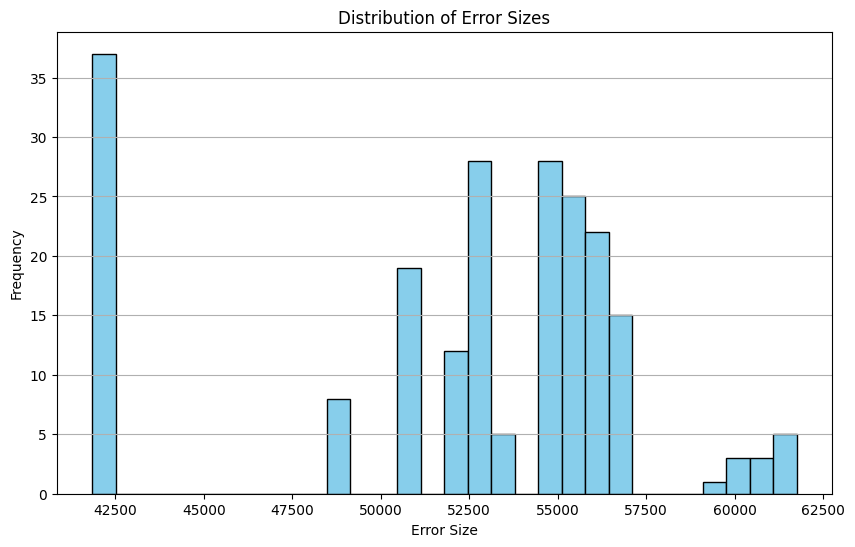

Histogram saved to /content/drive/MyDrive/Bertopic/output/error_size_distribution.png


<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
os.makedirs(output_dir, exist_ok=True)
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['Error_Size'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Error Sizes")
plt.xlabel("Error Size")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()
plt.savefig(os.path.join(output_dir, "error_size_distribution.png"))
print("Histogram saved to", os.path.join(output_dir, "error_size_distribution.png"))



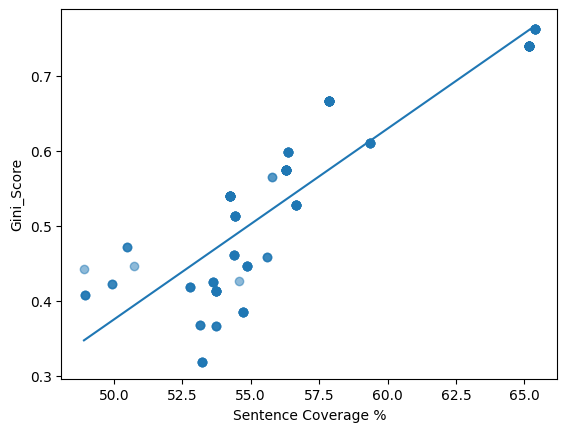

Spearman correlation = 0.89, p = 0.0000
Scatterplot saved to /content/drive/MyDrive/Bertopic/output/gini_score_vs_sentence_coverage.png


<Figure size 640x480 with 0 Axes>

In [33]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from scipy import stats
sort_metrics = metrics_df.sort_values(by='Error_Size', ascending=True)

def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['Gini_Score']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage %")
plt.ylabel("Gini_Score")

plt.scatter(x, y, alpha=0.5)
plt.plot(x, mymodel)
plt.show()
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")
plt.savefig(os.path.join(output_dir, "gini_score_vs_sentence_coverage.png"))
print("Scatterplot saved to", os.path.join(output_dir, "gini_score_vs_sentence_coverage.png"))

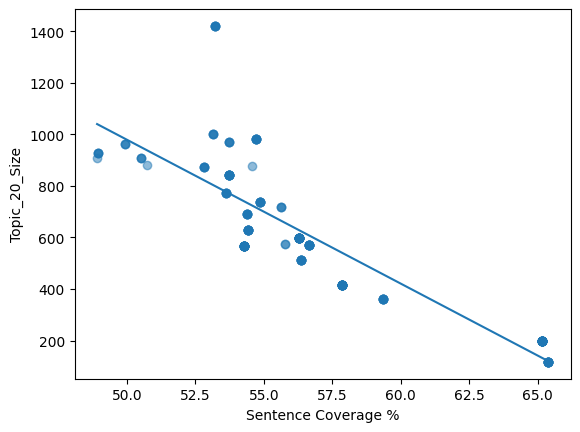

Spearman correlation = -0.88, p = 0.0000
Scatterplot saved to /content/drive/MyDrive/Bertopic/output/topic_20_size_vs_sentence_coverage.png


<Figure size 640x480 with 0 Axes>

In [34]:
sort_metrics = metrics_df.sort_values(by='Error_Size', ascending=True)

import matplotlib.pyplot as plt
from scipy import stats

def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['Topic_20_Size']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage %")
plt.ylabel("Topic_20_Size")

plt.scatter(x, y, alpha=0.5)
plt.plot(x, mymodel)
plt.show()
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")
plt.savefig(os.path.join(output_dir, "topic_20_size_vs_sentence_coverage.png"))
print("Scatterplot saved to", os.path.join(output_dir, "topic_20_size_vs_sentence_coverage.png"))

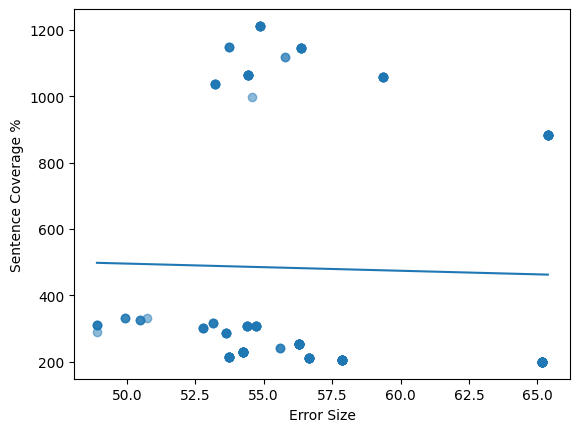

Spearman correlation = -0.34, p = 0.0000
Scatterplot saved to /content/drive/MyDrive/Bertopic/output/stability_score_vs_sentence_coverage.png


<Figure size 640x480 with 0 Axes>

In [36]:
sort_metrics = metrics_df.sort_values(by='Error_Size', ascending=True)


def myfunc(x):
  return slope * x + intercept


x = sort_metrics['Percentage Appearance']
y = sort_metrics['Stability_Score']

slope, intercept, r, p, std_err = stats.linregress(x, y)

mymodel = list(map(myfunc, x))
plt.xlabel("Error Size")
plt.ylabel("Sentence Coverage %")

plt.scatter(x, y, alpha=0.5)
plt.plot(x, mymodel)
plt.show()
rho, p_value = spearmanr(x, y)
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")
plt.savefig(os.path.join(output_dir, "stability_score_vs_sentence_coverage.png"))
print("Scatterplot saved to", os.path.join(output_dir, "stability_score_vs_sentence_coverage.png"))

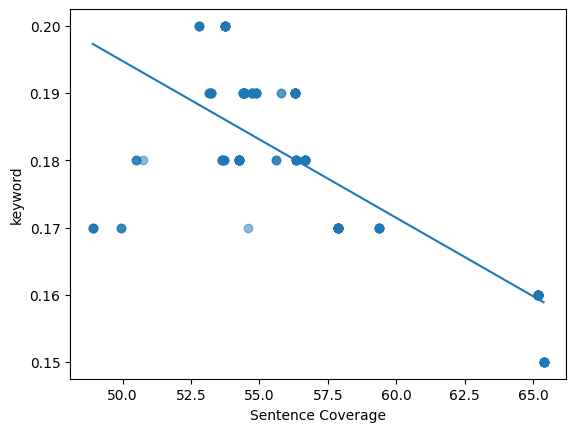

Scatterplot saved to /content/drive/MyDrive/Bertopic/output/keyword_freq_score_vs_sentence_coverage.png


<Figure size 640x480 with 0 Axes>

In [37]:
from scipy.stats import spearmanr

sort_metrics = metrics_df.sort_values(by='Error_Size', ascending=True)


x = sort_metrics['Percentage Appearance']
y = sort_metrics['Keyword_Freq_Score']



slope, intercept, r, p, std_err = stats.linregress(x, y)


mymodel = list(map(myfunc, x))
plt.xlabel("Sentence Coverage")
plt.ylabel("keyword")

plt.scatter(x, y, alpha=0.5)
plt.plot(x, mymodel)
plt.show()


rho, p_value = spearmanr(x, y)
plt.savefig(os.path.join(output_dir, "keyword_freq_score_vs_sentence_coverage.png"))
print("Scatterplot saved to", os.path.join(output_dir, "keyword_freq_score_vs_sentence_coverage.png"))

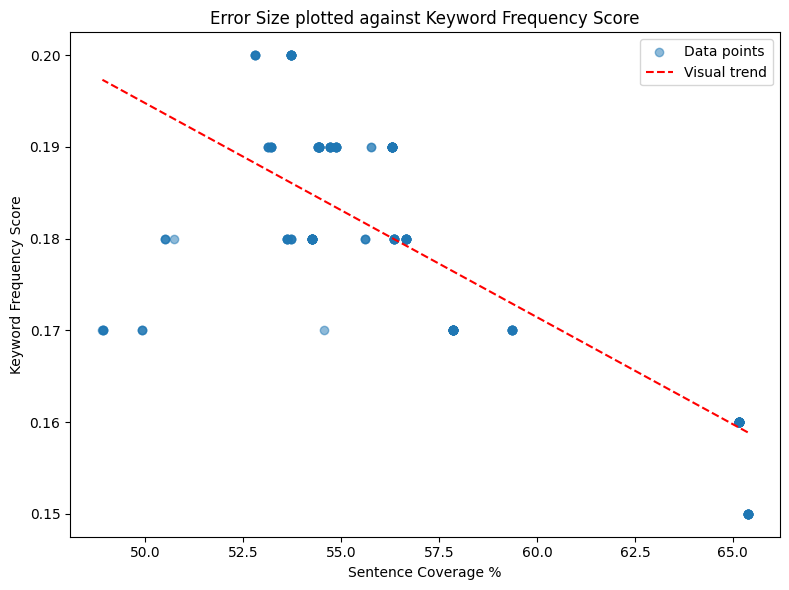

Spearman correlation = -0.66, p = 0.0000


In [38]:

import matplotlib.pyplot as plt
from scipy.stats import spearmanr
sort_metrics = metrics_df.sort_values(by='Error_Size', ascending=True)

x = sort_metrics["Percentage Appearance"]
y = sort_metrics["Keyword_Freq_Score"]

# Spearman correlation
rho, p_value = spearmanr(x, y)

# Optional: linear trend line just for visual orientation
slope, intercept = np.polyfit(x, y, deg=1)
mymodel = slope * x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label="Data points")
plt.plot(x, mymodel, color="red", linestyle="--", label="Visual trend")
plt.xlabel("Sentence Coverage %")
plt.ylabel("Keyword Frequency Score")
plt.title(f"Percentage Appearance plotted against Keyword Frequency Score")
plt.legend()
plt.tight_layout()
plt.show()
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")


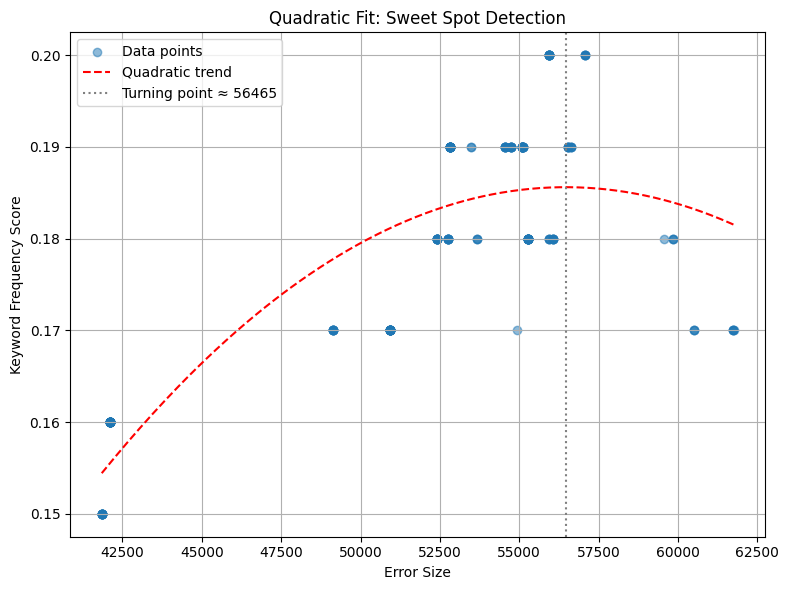

🟠 Estimated sweet spot at Error Size ≈ 56465 with Keyword Freq ≈ 0.186
The suggested threshold that should not be exceeded 1.0813 times the mean Error Size
Scatterplot saved to /content/drive/MyDrive/Bertopic/output/sweet_spot_detection.png


<Figure size 640x480 with 0 Axes>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
sort_metrics = metrics_df.sort_values(by='Error_Size', ascending=True)

# Your actual data
x = sort_metrics["Error_Size"]
y = sort_metrics["Keyword_Freq_Score"]

# Quadratic fit
coeffs = np.polyfit(x, y, 2)  # ax² + bx + c
poly = np.poly1d(coeffs)
x_fit = np.linspace(x.min(), x.max(), 200)
y_fit = poly(x_fit)

# Find turning point
turning_point = -coeffs[1] / (2 * coeffs[0])
peak_score = poly(turning_point)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label="Data points")
plt.plot(x_fit, y_fit, 'r--', label="Quadratic trend")
plt.axvline(turning_point, color="grey", linestyle=":", label=f"Turning point ≈ {int(turning_point)}")
plt.title("Quadratic Fit: Sweet Spot Detection")
plt.xlabel("Error Size")
plt.ylabel("Keyword Frequency Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"🟠 Estimated sweet spot at Error Size ≈ {int(turning_point)} with Keyword Freq ≈ {peak_score:.3f}")

thresh = round(int(turning_point)/ sort_metrics["Error_Size"].mean(),4)
print(f"The suggested threshold that should not be exceeded {thresh} times the mean Error Size")
plt.savefig(os.path.join(output_dir, "sweet_spot_detection.png"))
print("Scatterplot saved to", os.path.join(output_dir, "sweet_spot_detection.png"))

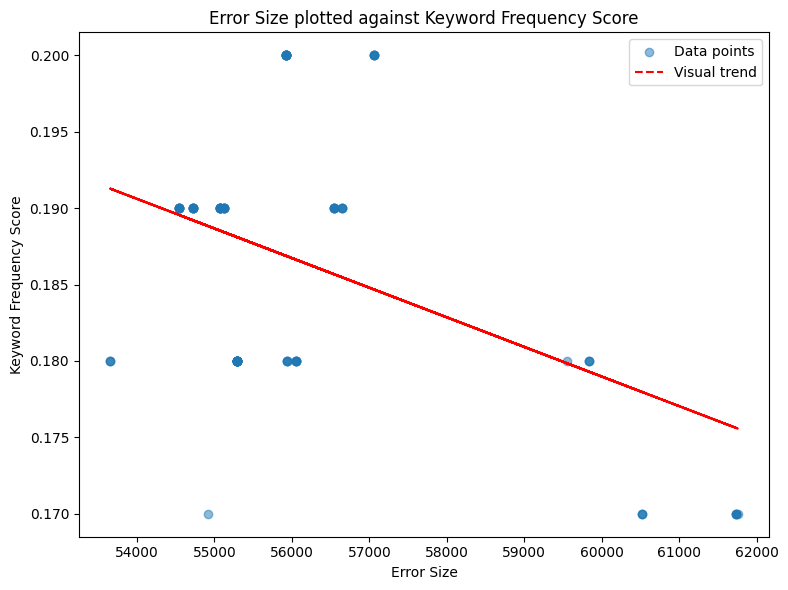

Spearman correlation = -0.19, p = 0.0486
Scatterplot saved to /content/drive/MyDrive/Bertopic/output/post_turning_error_size_vs_keyword_freq_score.png


<Figure size 640x480 with 0 Axes>

In [47]:
# Let's double check to confirm this is a pattern
# We're doing 0.95* the turning point to give a fuzzier size to make sure it is robust
sort_metrics = metrics_df[metrics_df["Error_Size"] > (int(turning_point)*0.95)]
import numpy as np
import matplotlib.pyplot as plt

x = sort_metrics["Error_Size"]
y = sort_metrics["Keyword_Freq_Score"]

rho, p_value = spearmanr(x, y)

# Optional: linear trend line just for visual orientation
slope, intercept = np.polyfit(x, y, deg=1)
mymodel = slope * x + intercept

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, label="Data points")
plt.plot(x, mymodel, color="red", linestyle="--", label="Visual trend")
plt.xlabel("Error Size")
plt.ylabel("Keyword Frequency Score")
plt.title(f"Error Size plotted against Keyword Frequency Score")
plt.legend()
plt.tight_layout()
plt.show()
print(f"Spearman correlation = {rho:.2f}, p = {p_value:.4f}")
plt.savefig(os.path.join(output_dir, "post_turning_error_size_vs_keyword_freq_score.png"))
print("Scatterplot saved to", os.path.join(output_dir, "post_turning_error_size_vs_keyword_freq_score.png"))
